# 11__snp_del_comparison
# comparing SNP effect sizes to deletion effect sizes

in this notebook, i compare SNP effect sizes (log2(alt/ref)) to deletion effect sizes (log2(del/ref)) and also determine how often a regulatory SNP overlaps "peaks" found by MIND

------

figures in this notebook:
- **Fig S17A**: scatter plot b/w SNP and del effect sizes in HepG2 and K562
- **Fig 4E and S17B**: bar plot of del effect sizes with SNP plot below for DLEU1 and MEG3

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sys
import time

from decimal import Decimal
from os import walk
from scipy import stats
from scipy.stats import spearmanr
from statsmodels.sandbox.stats import multicomp

# import utils
sys.path.append("../../utils")
from plotting_utils import *
from misc_utils import *
from norm_utils import *
from snp_utils import *
from del_utils import *

%matplotlib inline

In [2]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE
np.random.seed(SEED)

## variables

In [3]:
snp_dir = "../../data/07__snps"
del_dir = "../../data/06__tfbs_results"

In [4]:
hepg2_del_dir = "%s/HepG2/0__peaks" % del_dir
k562_del_dir = "%s/K562/0__peaks" % del_dir

In [5]:
hepg2_snp_file = "%s/HepG2__POOL2_active_snp_results.txt" % snp_dir
k562_snp_file = "%s/K562__POOL2_active_snp_results.txt" % snp_dir

In [6]:
index_file = "../../data/00__index/dels_oligo_pool.index.txt"

## 1. import data

In [7]:
hepg2_snps = pd.read_table(hepg2_snp_file, sep="\t")
k562_snps = pd.read_table(k562_snp_file, sep="\t")
hepg2_snps.head()

,unique_id,wt_id,SNP,rna_3_wt_med,rna_4_wt_med,rna_5_wt_med,rna_6_wt_med,rna_7_wt_med,rna_8_wt_med,rna_9_wt_med,...,combined_padj,rna_3_sig,rna_4_sig,rna_5_sig,rna_6_sig,rna_7_sig,rna_8_sig,rna_9_sig,rna_10_sig,combined_sig
0,WILDTYPE_SNP_INDIV__Enhancer.noflip.NA__chr11:...,WILDTYPE_BUT_HAS_SNP__Enhancer.noflip.NA__chr1...,rs565943512,-0.203456,0.071141,0.089584,0.075924,0.054592,-0.059412,0.098149,...,1.000000e+00,not sig,not sig,not sig,not sig,not sig,not sig,not sig,not sig,not sig
1,WILDTYPE_SNP_INDIV__Enhancer.noflip.NA__chr11:...,WILDTYPE_BUT_HAS_SNP__Enhancer.noflip.NA__chr1...,rs534921281,-0.203456,0.071141,0.089584,0.075924,0.054592,-0.059412,0.098149,...,1.000000e+00,not sig,not sig,not sig,not sig,not sig,not sig,not sig,not sig,not sig
2,WILDTYPE_SNP_INDIV__Enhancer.noflip.NA__chr11:...,WILDTYPE_BUT_HAS_SNP__Enhancer.noflip.NA__chr1...,rs554579505,-0.203456,0.071141,0.089584,0.075924,0.054592,-0.059412,0.098149,...,1.357119e-04,not sig,not sig,not sig,not sig,not sig,not sig,not sig,not sig,sig
3,WILDTYPE_SNP_INDIV__Enhancer.noflip.NA__chr11:...,WILDTYPE_BUT_HAS_SNP__Enhancer.noflip.NA__chr1...,rs574466865,-0.203456,0.071141,0.089584,0.075924,0.054592,-0.059412,0.098149,...,1.841921e-26,sig,sig,not sig,sig,sig,sig,sig,sig,sig
4,WILDTYPE_SNP_INDIV__Enhancer.noflip.NA__chr11:...,WILDTYPE_BUT_HAS_SNP__Enhancer.noflip.NA__chr1...,rs116484767,-0.203456,0.071141,0.089584,0.075924,0.054592,-0.059412,0.098149,...,2.523062e-23,not sig,not sig,sig,not sig,sig,sig,not sig,sig,sig


In [8]:
index = pd.read_table(index_file, sep="\t")
index.head()

,full_oligo,oligo_type,oligo_id,dupe_info,seq_name,tile_name,chr,locus_start,locus_end,strand,...,tile_number,local_start,local_end,RE_count_1,RE_count_2,RE_count_3,SNP,barcode,element,unique_id
0,ACTGGCCGCTTCACTGTGTTCCAGAAAACAGCAGCAAACAGAGGCC...,WILDTYPE_BUT_HAS_SNP,1.2.0.0.0.0.1,none,Enhancer.noflip.NA__chr11:65187297-65188198__c...,Enhancer.noflip.NA__chr11:65187297-65188198__c...,chr11,65187510.0,65187718.0,-,...,2.0,94.0,208.0,1,1,0,none,GATTCGTCGTG,TGTTCCAGAAAACAGCAGCAAACAGAGGCCCTTGGATTCCGGGGTG...,WILDTYPE_BUT_HAS_SNP__Enhancer.noflip.NA__chr1...
1,ACTGGCCGCTTCACTGTGTTCCAGAAAACAGCAGCAAACAGAGGCC...,WILDTYPE_BUT_HAS_SNP,1.2.0.0.0.0.2,none,Enhancer.noflip.NA__chr11:65187297-65188198__c...,Enhancer.noflip.NA__chr11:65187297-65188198__c...,chr11,65187510.0,65187718.0,-,...,2.0,94.0,208.0,1,1,0,none,CGAGATAAGTT,TGTTCCAGAAAACAGCAGCAAACAGAGGCCCTTGGATTCCGGGGTG...,WILDTYPE_BUT_HAS_SNP__Enhancer.noflip.NA__chr1...
2,ACTGGCCGCTTCACTGTGTTCCAGAAAACAGCAGCAAACAGAGGCC...,WILDTYPE_BUT_HAS_SNP,1.2.0.0.0.0.3,none,Enhancer.noflip.NA__chr11:65187297-65188198__c...,Enhancer.noflip.NA__chr11:65187297-65188198__c...,chr11,65187510.0,65187718.0,-,...,2.0,94.0,208.0,1,1,0,none,CTCGATTAAGG,TGTTCCAGAAAACAGCAGCAAACAGAGGCCCTTGGATTCCGGGGTG...,WILDTYPE_BUT_HAS_SNP__Enhancer.noflip.NA__chr1...
3,ACTGGCCGCTTCACTGTGTTCCAGAAAACAGCAGCAAACAGAGGCC...,WILDTYPE_BUT_HAS_SNP,1.2.0.0.0.0.4,none,Enhancer.noflip.NA__chr11:65187297-65188198__c...,Enhancer.noflip.NA__chr11:65187297-65188198__c...,chr11,65187510.0,65187718.0,-,...,2.0,94.0,208.0,1,1,0,none,TGAATAAGTCA,TGTTCCAGAAAACAGCAGCAAACAGAGGCCCTTGGATTCCGGGGTG...,WILDTYPE_BUT_HAS_SNP__Enhancer.noflip.NA__chr1...
4,ACTGGCCGCTTCACTGTGTTCCAGAAAACAGCAGCAAACAGAGGCC...,WILDTYPE_BUT_HAS_SNP,1.2.0.0.0.0.5,none,Enhancer.noflip.NA__chr11:65187297-65188198__c...,Enhancer.noflip.NA__chr11:65187297-65188198__c...,chr11,65187510.0,65187718.0,-,...,2.0,94.0,208.0,1,1,0,none,CCTAATCGACA,TGTTCCAGAAAACAGCAGCAAACAGAGGCCCTTGGATTCCGGGGTG...,WILDTYPE_BUT_HAS_SNP__Enhancer.noflip.NA__chr1...


In [9]:
hepg2_files = []
for (dirpath, dirnames, filenames) in walk(hepg2_del_dir):
    hepg2_files.extend(filenames)
    break

In [10]:
k562_files = []
for (dirpath, dirnames, filenames) in walk(k562_del_dir):
    k562_files.extend(filenames)
    break

In [11]:
k562_files[0:5]

['enhancer_MALAT1__pX__tile1__minus.tfbs_peaks.txt',
 'enhancer_MALAT1__pX__tile2__minus.tfbs_peaks.txt',
 'FALEC__p1__tile2__plus.tfbs_peaks.txt',
 'GAS5__p1__tile1__minus.tfbs_peaks.txt',
 'GAS5__p1__tile2__minus.tfbs_peaks.txt']

In [12]:
hepg2_dels = {}
k562_dels = {}
for files, f_dir, dels in zip([hepg2_files, k562_files], [hepg2_del_dir, k562_del_dir], [hepg2_dels, k562_dels]):
    for f in files:
        name = f.split(".")[0]
        df = pd.read_table("%s/%s" % (f_dir, f), sep="\t")
        dels[name] = df

In [13]:
hepg2_dels["ZFAS1__p1__tile2__plus"].head()

,delpos,mean.log2FC,sd,se,seq,padj,sig,wt_activ,wt_l2fc,wt_class,tile_chr,tile_start,tile_end,peak
0,11,0.063207,0.066139,0.023384,T,1.0,not sig,4.731591,5.759151,sig active,chr20,47895099.0,47895213.0,no peak
1,12,0.063207,0.066139,0.023384,T,1.0,not sig,4.731591,5.759151,sig active,chr20,47895099.0,47895213.0,no peak
2,13,-0.110958,0.071982,0.025450,C,1.0,not sig,4.731591,5.759151,sig active,chr20,47895099.0,47895213.0,no peak
3,14,-0.002866,0.035329,0.012491,G,1.0,not sig,4.731591,5.759151,sig active,chr20,47895099.0,47895213.0,no peak
4,15,-0.002866,0.035329,0.012491,G,1.0,not sig,4.731591,5.759151,sig active,chr20,47895099.0,47895213.0,no peak


## 2. parse names in snps & dels so they match

In [14]:
hepg2_snps["wt_id_new"] = hepg2_snps.apply(fix_snp_names, name_dict=NAME_DICT, loc_dict=LOC_DICT, axis=1)
k562_snps["wt_id_new"] = k562_snps.apply(fix_snp_names, name_dict=NAME_DICT, loc_dict=LOC_DICT, axis=1)
hepg2_snps.sample(5)

,unique_id,wt_id,SNP,rna_3_wt_med,rna_4_wt_med,rna_5_wt_med,rna_6_wt_med,rna_7_wt_med,rna_8_wt_med,rna_9_wt_med,...,rna_3_sig,rna_4_sig,rna_5_sig,rna_6_sig,rna_7_sig,rna_8_sig,rna_9_sig,rna_10_sig,combined_sig,wt_id_new
132,WILDTYPE_SNP_INDIV__Antisense.noflip.NA__p1@ME...,WILDTYPE_BUT_HAS_SNP__Antisense.noflip.NA__p1@...,rs551103617,-1.168208,-1.086713,-0.960945,-0.786083,-1.211968,-1.003390,-0.969335,...,NA__too_many_rep_NAs,NA__too_many_rep_NAs,NA__too_many_rep_NAs,NA__too_many_rep_NAs,NA__too_many_rep_NAs,NA__too_many_rep_NAs,NA__too_many_rep_NAs,NA__too_many_rep_NAs,NA__too_many_rep_NAs,MEG3__p1__tile1__plus
155,WILDTYPE_SNP_INDIV__Antisense.noflip.NA__p1@ZN...,WILDTYPE_BUT_HAS_SNP__Antisense.noflip.NA__p1@...,rs545020435,4.508305,5.162460,4.070192,4.484726,4.752297,4.928802,4.974547,...,sig,not sig,sig,sig,sig,sig,sig,sig,sig,ZFAS1__p1__tile2__plus
197,WILDTYPE_SNP_INDIV__Lincrna.noflip.NA__p1@JPX_...,WILDTYPE_BUT_HAS_SNP__Lincrna.noflip.NA__p1@JP...,.,1.470671,1.992998,1.511285,1.531339,1.706678,1.790100,1.754659,...,not sig,not sig,not sig,not sig,not sig,not sig,not sig,not sig,not sig,JPX__p1__tile2__plus
94,WILDTYPE_SNP_INDIV__Lincrna.noflip.NA__p1@NEAT...,WILDTYPE_BUT_HAS_SNP__Lincrna.noflip.NA__p1@NE...,rs183088432,-0.240064,-0.048294,-0.256743,-0.135018,-0.023263,-0.130823,-0.082726,...,not sig,not sig,not sig,not sig,not sig,not sig,not sig,not sig,not sig,NEAT1__p1__tile2__plus
140,WILDTYPE_SNP_INDIV__mrna.noflip.NA__p1@IRX5__c...,WILDTYPE_BUT_HAS_SNP__mrna.noflip.NA__p1@IRX5_...,rs571458377,-1.050192,-1.179402,-0.882060,-0.880365,-1.049089,-1.010428,-0.905534,...,NA__too_many_rep_NAs,NA__too_many_rep_NAs,NA__too_many_rep_NAs,NA__too_many_rep_NAs,NA__too_many_rep_NAs,NA__too_many_rep_NAs,NA__too_many_rep_NAs,NA__too_many_rep_NAs,NA__too_many_rep_NAs,IRX5__p1__tile2__plus


## 3. find bp num of SNP per tile

In [15]:
hepg2_wt_seqs = index[index["unique_id"].isin(hepg2_snps["wt_id"])]
hepg2_wt_seqs = hepg2_wt_seqs[["unique_id", "element"]].drop_duplicates()
hepg2_wt_seqs_dict = {k:v for k,v in zip(list(hepg2_wt_seqs["unique_id"]), list(hepg2_wt_seqs["element"]))}
len(hepg2_wt_seqs_dict)

53

In [16]:
k562_wt_seqs = index[index["unique_id"].isin(k562_snps["wt_id"])]
k562_wt_seqs = k562_wt_seqs[["unique_id", "element"]].drop_duplicates()
k562_wt_seqs_dict = {k:v for k,v in zip(list(k562_wt_seqs["unique_id"]), list(k562_wt_seqs["element"]))}
len(k562_wt_seqs_dict)

53

In [17]:
# same in both, just make map w/ hepg2
wt_seqs_dict = hepg2_wt_seqs_dict.copy()
snp_seqs = index[index["unique_id"].isin(hepg2_snps["unique_id"])]
snp_seqs = snp_seqs[["unique_id", "element"]].drop_duplicates()
snp_seqs_dict = {k:v for k,v in zip(list(snp_seqs["unique_id"]), list(snp_seqs["element"]))}
len(snp_seqs_dict)

199

In [18]:
snps_grp = hepg2_snps.groupby("wt_id")["unique_id"].agg("count").reset_index()
snps_grp.sort_values(by="unique_id", ascending=False).head()

,wt_id,unique_id
1,CONTROL_BUT_HAS_SNP__control.noflip.NA__p1@HBB...,11
13,WILDTYPE_BUT_HAS_SNP__Antisense.noflip.NA__p1@...,11
6,WILDTYPE_BUT_HAS_SNP__Antisense.noflip.NA__p1@...,9
38,WILDTYPE_BUT_HAS_SNP__Lincrna.noflip.NA__p1@MA...,9
3,CONTROL_BUT_HAS_SNP__control.noflip.NA__p1@S10...,7


In [19]:
hepg2_snps["snp_pos"] = hepg2_snps.apply(get_snp_pos, wt_seqs_dict=wt_seqs_dict, snp_seqs_dict=snp_seqs_dict, max_snps_per_tile=11,
                                         axis=1)
k562_snps["snp_pos"] = k562_snps.apply(get_snp_pos, wt_seqs_dict=wt_seqs_dict, snp_seqs_dict=snp_seqs_dict, max_snps_per_tile=11,
                                       axis=1)
hepg2_snps.sample(5)

,unique_id,wt_id,SNP,rna_3_wt_med,rna_4_wt_med,rna_5_wt_med,rna_6_wt_med,rna_7_wt_med,rna_8_wt_med,rna_9_wt_med,...,rna_4_sig,rna_5_sig,rna_6_sig,rna_7_sig,rna_8_sig,rna_9_sig,rna_10_sig,combined_sig,wt_id_new,snp_pos
158,WILDTYPE_SNP_INDIV__Antisense.noflip.NA__p1@ZN...,WILDTYPE_BUT_HAS_SNP__Antisense.noflip.NA__p1@...,rs542676698,4.508305,5.162460,4.070192,4.484726,4.752297,4.928802,4.974547,...,not sig,sig,sig,sig,sig,sig,sig,sig,ZFAS1__p1__tile2__plus,69
187,WILDTYPE_SNP_INDIV__Antisense.noflip.NA__p2@FL...,WILDTYPE_BUT_HAS_SNP__Antisense.noflip.NA__p2@...,rs549508925,-0.803327,-0.364761,-0.653652,-0.744273,-0.556010,-0.521958,-0.665616,...,not sig,NA__too_many_rep_NAs,NA__too_many_rep_NAs,NA__too_many_rep_NAs,NA__too_many_rep_NAs,NA__too_many_rep_NAs,NA__too_many_rep_NAs,not sig,LINC_PINT__p2__tile2__minus,11
81,CONTROL_SNP_INDIV__control.noflip.NA__p1@HBB__...,CONTROL_BUT_HAS_SNP__control.noflip.NA__p1@HBB...,rsFakeHBB1,-0.654425,-0.593675,-0.604614,-0.724685,-0.759409,-0.652865,-0.591606,...,NA__too_many_rep_NAs,NA__too_many_rep_NAs,NA__too_many_rep_NAs,NA__too_many_rep_NAs,NA__too_many_rep_NAs,NA__too_many_rep_NAs,not sig,not sig,HBB__p1__tile2__minus,70
161,WILDTYPE_SNP_INDIV__Antisense.noflip.NA__p1@ZN...,WILDTYPE_BUT_HAS_SNP__Antisense.noflip.NA__p1@...,rs188154930,4.508305,5.162460,4.070192,4.484726,4.752297,4.928802,4.974547,...,not sig,not sig,not sig,not sig,not sig,not sig,not sig,not sig,ZFAS1__p1__tile2__plus,86
117,WILDTYPE_SNP_INDIV__Lincrna.noflip.NA__p1@MALA...,WILDTYPE_BUT_HAS_SNP__Lincrna.noflip.NA__p1@MA...,rs374669413,-0.471621,-0.590749,-0.794576,-1.104063,-0.483728,-0.635468,-0.739980,...,NA__too_many_rep_NAs,NA__too_many_rep_NAs,NA__too_many_rep_NAs,not sig,NA__too_many_rep_NAs,NA__too_many_rep_NAs,not sig,not sig,MALAT1__p1__tile2__plus,67


In [20]:
hepg2_snps.snp_pos.min()

0

In [21]:
hepg2_snps.snp_pos.max()

93

## 4. find SNPs that are significant
for now only look at SNPs that are significantly *down* from active tiles

In [22]:
hepg2_indiv_snps = hepg2_snps[~hepg2_snps["unique_id"].str.contains("HAPLO")]
hepg2_sig_snps = hepg2_indiv_snps[hepg2_indiv_snps["combined_sig"] == "sig"]
hepg2_not_sig_snps = hepg2_indiv_snps[(hepg2_indiv_snps["combined_sig"] == "not sig")]

k562_indiv_snps = k562_snps[~k562_snps["unique_id"].str.contains("HAPLO")]
k562_sig_snps = k562_indiv_snps[k562_indiv_snps["combined_sig"] == "sig"]
k562_not_sig_snps = k562_indiv_snps[(k562_indiv_snps["combined_sig"] == "not sig")]

In [23]:
len(hepg2_indiv_snps)

199

In [24]:
len(hepg2_sig_snps)

43

In [25]:
len(hepg2_not_sig_snps)

107

## 5. overlap peak data

In [26]:
def get_overlap(row, del_dfs):
    snp_loc = row["snp_pos"]
    try:
        df = del_dfs[row["wt_id_new"]]
    except KeyError:
        return "seq not tested"
    snp_loc_in_df_coords = snp_loc+11
    del_peak_locs = list(df[df["peak"] == "peak"]["delpos"])
    if snp_loc_in_df_coords in del_peak_locs:
        return "peak overlap"
    else:
        return "no peak overlap"

In [27]:
hepg2_sig_snps["overlap"] = hepg2_sig_snps.apply(get_overlap, del_dfs=hepg2_dels, axis=1)
k562_sig_snps["overlap"] = k562_sig_snps.apply(get_overlap, del_dfs=k562_dels, axis=1)
hepg2_sig_snps.sample(5)

,unique_id,wt_id,SNP,rna_3_wt_med,rna_4_wt_med,rna_5_wt_med,rna_6_wt_med,rna_7_wt_med,rna_8_wt_med,rna_9_wt_med,...,rna_5_sig,rna_6_sig,rna_7_sig,rna_8_sig,rna_9_sig,rna_10_sig,combined_sig,wt_id_new,snp_pos,overlap
14,WILDTYPE_SNP_INDIV__Enhancer.noflip.NA__chr11:...,WILDTYPE_BUT_HAS_SNP__Enhancer.noflip.NA__chr1...,rs533122912,2.849608,4.427455,2.654715,2.781941,3.247396,2.972265,3.206178,...,not sig,not sig,not sig,not sig,not sig,not sig,sig,enhancer_MALAT1__pX__tile2__minus,25,no peak overlap
82,CONTROL_SNP_INDIV__control.noflip.NA__p1@HBB__...,CONTROL_BUT_HAS_SNP__control.noflip.NA__p1@HBB...,rsFakeHBB-29,-0.654425,-0.593675,-0.604614,-0.724685,-0.759409,-0.652865,-0.591606,...,NA__too_many_rep_NAs,NA__too_many_rep_NAs,NA__too_many_rep_NAs,NA__too_many_rep_NAs,NA__too_many_rep_NAs,sig,sig,HBB__p1__tile2__minus,40,seq not tested
2,WILDTYPE_SNP_INDIV__Enhancer.noflip.NA__chr11:...,WILDTYPE_BUT_HAS_SNP__Enhancer.noflip.NA__chr1...,rs554579505,-0.203456,0.071141,0.089584,0.075924,0.054592,-0.059412,0.098149,...,not sig,not sig,not sig,not sig,not sig,not sig,sig,enhancer_NEAT1__pX__tile2__minus,68,no peak overlap
49,WILDTYPE_SNP_INDIV__Antisense.noflip.NA__p1@GA...,WILDTYPE_BUT_HAS_SNP__Antisense.noflip.NA__p1@...,rs552155993,4.537949,5.216113,4.013795,4.463320,4.729901,4.975706,5.005421,...,sig,sig,sig,sig,sig,sig,sig,GAS5__p1__tile2__minus,69,peak overlap
26,WILDTYPE_SNP_INDIV__Enhancer.noflip.NA__chr7:1...,WILDTYPE_BUT_HAS_SNP__Enhancer.noflip.NA__chr7...,rs185206187,-0.027349,0.078257,0.000455,0.030050,0.028186,0.125936,0.177038,...,sig,sig,sig,sig,sig,sig,sig,enhancer_LINC_PINT__pX__tile1__minus,79,peak overlap


In [28]:
hepg2_not_sig_snps["overlap"] = hepg2_not_sig_snps.apply(get_overlap, del_dfs=hepg2_dels, axis=1)
k562_not_sig_snps["overlap"] = k562_not_sig_snps.apply(get_overlap, del_dfs=k562_dels, axis=1)
hepg2_not_sig_snps.sample(5)

,unique_id,wt_id,SNP,rna_3_wt_med,rna_4_wt_med,rna_5_wt_med,rna_6_wt_med,rna_7_wt_med,rna_8_wt_med,rna_9_wt_med,...,rna_5_sig,rna_6_sig,rna_7_sig,rna_8_sig,rna_9_sig,rna_10_sig,combined_sig,wt_id_new,snp_pos,overlap
143,WILDTYPE_SNP_INDIV__Lincrna.flip.sense__p1@LOC...,WILDTYPE_BUT_HAS_SNP__Lincrna.flip.sense__p1@L...,rs534378029,0.216673,0.145058,0.191003,0.465888,-0.027743,0.058242,-0.032392,...,not sig,not sig,NA__too_many_rep_NAs,not sig,not sig,not sig,not sig,FENDRR__p1__tile2__minus,33,no peak overlap
102,WILDTYPE_SNP_INDIV__Lincrna.noflip.NA__p4@MALA...,WILDTYPE_BUT_HAS_SNP__Lincrna.noflip.NA__p4@MA...,rs187673447,-0.367781,-0.084951,-0.154970,-0.437636,-0.404438,-0.192628,-0.321164,...,not sig,not sig,not sig,not sig,not sig,not sig,not sig,MALAT1__p4__tile2__plus,2,no peak overlap
150,WILDTYPE_SNP_INDIV__Antisense.noflip.NA__p1@ZN...,WILDTYPE_BUT_HAS_SNP__Antisense.noflip.NA__p1@...,rs555698582,0.188461,0.140895,-0.147010,-0.462663,0.052852,0.089905,-0.068920,...,not sig,not sig,not sig,not sig,not sig,not sig,not sig,ZFAS1__p1__tile1__plus,21,no peak overlap
74,CONTROL_SNP_INDIV__control.noflip.NA__p1@HBB__...,CONTROL_BUT_HAS_SNP__control.noflip.NA__p1@HBB...,rs386134236,-0.654425,-0.593675,-0.604614,-0.724685,-0.759409,-0.652865,-0.591606,...,not sig,NA__too_many_rep_NAs,NA__too_many_rep_NAs,not sig,not sig,not sig,not sig,HBB__p1__tile2__minus,68,seq not tested
194,WILDTYPE_SNP_INDIV__Lincrna.noflip.NA__p1@JPX_...,WILDTYPE_BUT_HAS_SNP__Lincrna.noflip.NA__p1@JP...,.,0.827644,1.124211,0.419988,0.578862,0.866889,0.793047,1.055180,...,not sig,not sig,not sig,not sig,not sig,not sig,not sig,JPX__p1__tile1__plus,31,no peak overlap


In [29]:
for cell, sig_snps in zip(["HepG2", "K562"], [hepg2_sig_snps, k562_sig_snps]):
    print(cell)
    print(sig_snps.overlap.value_counts())
    print("")

HepG2
no peak overlap    22
peak overlap       12
seq not tested      9
Name: overlap, dtype: int64

K562
peak overlap       8
no peak overlap    3
Name: overlap, dtype: int64



In [30]:
print("significantly down-reg snps only")
for cell, sig_snps in zip(["HepG2", "K562"], [hepg2_sig_snps, k562_sig_snps]):
    print(cell)
    sig_down_snps = sig_snps[sig_snps["combined_l2fc"] < 0]
    print(sig_down_snps.overlap.value_counts())
    print("")

significantly down-reg snps only
HepG2
no peak overlap    12
peak overlap       11
seq not tested      9
Name: overlap, dtype: int64

K562
peak overlap       8
no peak overlap    2
Name: overlap, dtype: int64



In [31]:
print("not significant SNPs")
for cell, not_sig_snps in zip(["HepG2", "K562"], [hepg2_not_sig_snps, k562_not_sig_snps]):
    print(cell)
    print(not_sig_snps.overlap.value_counts())
    print("")

not significant SNPs
HepG2
no peak overlap    87
seq not tested     20
Name: overlap, dtype: int64

K562
no peak overlap    57
seq not tested     16
peak overlap        2
Name: overlap, dtype: int64



## 6. which SNPs are reg but not in peaks?

In [32]:
hepg2_sig_down_snps = hepg2_sig_snps[hepg2_sig_snps["combined_l2fc"] < 0]
k562_sig_down_snps = k562_sig_snps[k562_sig_snps["combined_l2fc"] < 0]
hepg2_sig_down_snps[hepg2_sig_down_snps["overlap"] == "no peak overlap"]

,unique_id,wt_id,SNP,rna_3_wt_med,rna_4_wt_med,rna_5_wt_med,rna_6_wt_med,rna_7_wt_med,rna_8_wt_med,rna_9_wt_med,...,rna_5_sig,rna_6_sig,rna_7_sig,rna_8_sig,rna_9_sig,rna_10_sig,combined_sig,wt_id_new,snp_pos,overlap
2,WILDTYPE_SNP_INDIV__Enhancer.noflip.NA__chr11:...,WILDTYPE_BUT_HAS_SNP__Enhancer.noflip.NA__chr1...,rs554579505,-0.203456,0.071141,0.089584,0.075924,0.054592,-0.059412,0.098149,...,not sig,not sig,not sig,not sig,not sig,not sig,sig,enhancer_NEAT1__pX__tile2__minus,68,no peak overlap
4,WILDTYPE_SNP_INDIV__Enhancer.noflip.NA__chr11:...,WILDTYPE_BUT_HAS_SNP__Enhancer.noflip.NA__chr1...,rs116484767,-0.203456,0.071141,0.089584,0.075924,0.054592,-0.059412,0.098149,...,sig,not sig,sig,sig,not sig,sig,sig,enhancer_NEAT1__pX__tile2__minus,17,no peak overlap
28,WILDTYPE_SNP_INDIV__Enhancer.noflip.NA__chr7:1...,WILDTYPE_BUT_HAS_SNP__Enhancer.noflip.NA__chr7...,rs76140042,-0.027349,0.078257,0.000455,0.030050,0.028186,0.125936,0.177038,...,not sig,not sig,not sig,not sig,not sig,not sig,sig,enhancer_LINC_PINT__pX__tile1__minus,31,no peak overlap
51,WILDTYPE_SNP_INDIV__Antisense.noflip.NA__p1@GA...,WILDTYPE_BUT_HAS_SNP__Antisense.noflip.NA__p1@...,rs534725244,4.537949,5.216113,4.013795,4.463320,4.729901,4.975706,5.005421,...,sig,sig,sig,sig,sig,sig,sig,GAS5__p1__tile2__minus,42,no peak overlap
61,WILDTYPE_SNP_INDIV__mrna.noflip.NA__p1@ZBTB37_...,WILDTYPE_BUT_HAS_SNP__mrna.noflip.NA__p1@ZBTB3...,rs565695192,3.193982,4.770731,2.986971,3.226308,3.515352,3.907380,4.111768,...,not sig,not sig,not sig,not sig,not sig,sig,sig,ZBTB37__p1__tile2__plus,90,no peak overlap
62,WILDTYPE_SNP_INDIV__Lincrna.noflip.NA__p1@LINC...,WILDTYPE_BUT_HAS_SNP__Lincrna.noflip.NA__p1@LI...,rs3738203,1.483912,1.295548,0.736375,1.047722,1.347364,1.534655,1.009682,...,not sig,NA__too_many_rep_NAs,not sig,sig,not sig,not sig,sig,LINC00467__p1__tile1__plus,22,no peak overlap
101,WILDTYPE_SNP_INDIV__Lincrna.noflip.NA__p4@MALA...,WILDTYPE_BUT_HAS_SNP__Lincrna.noflip.NA__p4@MA...,rs528878563,-0.367781,-0.084951,-0.154970,-0.437636,-0.404438,-0.192628,-0.321164,...,not sig,not sig,not sig,not sig,not sig,not sig,sig,MALAT1__p4__tile2__plus,0,no peak overlap
120,WILDTYPE_SNP_INDIV__Antisense.noflip.NA__p1@HO...,WILDTYPE_BUT_HAS_SNP__Antisense.noflip.NA__p1@...,rs532719220,0.127354,0.358772,0.099024,0.201978,0.236495,0.289791,0.341169,...,not sig,not sig,sig,not sig,sig,sig,sig,HOTAIR__p1__tile2__minus,69,no peak overlap
121,WILDTYPE_SNP_INDIV__Antisense.noflip.NA__p1@HO...,WILDTYPE_BUT_HAS_SNP__Antisense.noflip.NA__p1@...,rs548034593,0.127354,0.358772,0.099024,0.201978,0.236495,0.289791,0.341169,...,sig,sig,sig,sig,sig,sig,sig,HOTAIR__p1__tile2__minus,28,no peak overlap
156,WILDTYPE_SNP_INDIV__Antisense.noflip.NA__p1@ZN...,WILDTYPE_BUT_HAS_SNP__Antisense.noflip.NA__p1@...,rs182899650,4.508305,5.162460,4.070192,4.484726,4.752297,4.928802,4.974547,...,not sig,not sig,not sig,not sig,not sig,not sig,sig,ZFAS1__p1__tile2__plus,59,no peak overlap


## 7. institute l2fc foldchange on snps

In [33]:
hepg2_sig_down_snps_filt = hepg2_sig_down_snps[hepg2_sig_down_snps["combined_l2fc"] <= -1]
k562_sig_down_snps_filt = k562_sig_down_snps[k562_sig_down_snps["combined_l2fc"] <= -1]
print(len(hepg2_sig_down_snps_filt))
print(len(k562_sig_down_snps_filt))

6
7


In [34]:
hepg2_sig_down_snps_filt.overlap.value_counts()

seq not tested     3
peak overlap       2
no peak overlap    1
Name: overlap, dtype: int64

In [35]:
k562_sig_down_snps_filt.overlap.value_counts()

peak overlap       6
no peak overlap    1
Name: overlap, dtype: int64

## 8. plot correlation b/w deletions & snps

In [36]:
all_hepg2_snp_ids = []
all_k562_snp_ids = []
all_hepg2_del_vals = []
all_hepg2_snp_vals = []
all_k562_del_vals = []
all_k562_snp_vals = []

for all_snp_ids, snps, dels, all_del_vals, all_snp_vals in zip([all_hepg2_snp_ids, all_k562_snp_ids], 
                                                               [hepg2_snps, k562_snps], [hepg2_dels, k562_dels], 
                                                               [all_hepg2_del_vals, all_k562_del_vals], 
                                                               [all_hepg2_snp_vals, all_k562_snp_vals]):
    for seq in list(snps.wt_id_new):
        if seq in dels:
            del_df = dels[seq]

            # put del_df bps in terms of 1-94
            del_df["delpos_fixed"] = list(range(1, 95))

            snp_df = snps[(snps["wt_id_new"] == seq)]
            merged = snp_df[["wt_id_new", "SNP", "snp_pos", 
                             "combined_l2fc", "combined_sig"]].merge(del_df, left_on="snp_pos", 
                                                                     right_on="delpos_fixed")
            snp_ids = list(merged["SNP"])
            del_vals = list(merged["mean.log2FC"])
            snp_vals = list(merged["combined_l2fc"])
            all_snp_ids.extend(snp_ids)
            all_del_vals.extend(del_vals)
            all_snp_vals.extend(snp_vals)

        else:
            continue

In [37]:
hepg2_snp_del_df = pd.DataFrame()
hepg2_snp_del_df["SNP"] = all_hepg2_snp_ids
hepg2_snp_del_df["del_val"] = all_hepg2_del_vals
hepg2_snp_del_df["snp_val"] = all_hepg2_snp_vals
hepg2_snp_del_df.drop_duplicates(inplace=True)
hepg2_snp_del_nonan = hepg2_snp_del_df[~(pd.isnull(hepg2_snp_del_df["del_val"])) 
                                       & ~(pd.isnull(hepg2_snp_del_df["snp_val"]))]
hepg2_snp_del_nonan.sort_values(by="snp_val").head()

,SNP,del_val,snp_val
429,rs181891917,-1.428417,-1.511589
394,rs535708498,-1.621036,-1.120237
370,rs548034593,-0.672252,-1.119478
99,rs185206187,-1.319387,-0.986767
121,rs552155993,-1.239350,-0.975369


In [38]:
k562_snp_del_df = pd.DataFrame()
k562_snp_del_df["SNP"] = all_k562_snp_ids
k562_snp_del_df["del_val"] = all_k562_del_vals
k562_snp_del_df["snp_val"] = all_k562_snp_vals
k562_snp_del_df.drop_duplicates(inplace=True)
k562_snp_del_nonan = k562_snp_del_df[~(pd.isnull(k562_snp_del_df["del_val"])) 
                                     & ~(pd.isnull(k562_snp_del_df["snp_val"]))]
k562_snp_del_nonan.sort_values(by="snp_val").head()

,SNP,del_val,snp_val
3,rs187673447,-0.168135,-1.523038
71,rs552155993,-1.595267,-1.471511
2,rs528878563,-1.303614,-1.462840
530,.,-0.192425,-1.456168
347,rs577754984,-1.610978,-1.373954


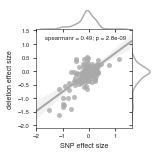

In [39]:
g = sns.jointplot(data=hepg2_snp_del_nonan, x="snp_val", y="del_val", kind="reg", space=0, size=2.2, 
                  stat_func=spearmanr, 
                  marginal_kws={"hist": False}, color="darkgrey", scatter_kws={"s": 25})
g.set_axis_labels("SNP effect size", "deletion effect size")
g.savefig("Fig_S17A_HepG2.pdf", dpi="figure", bbox_inches="tight")

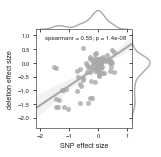

In [40]:
g = sns.jointplot(data=k562_snp_del_nonan, x="snp_val", y="del_val", kind="reg", space=0, size=2.2, 
                  stat_func=spearmanr, 
                  marginal_kws={"hist": False}, color="darkgrey", scatter_kws={"s": 25})
g.set_axis_labels("SNP effect size", "deletion effect size")
g.savefig("Fig_S17A_K562.pdf", dpi="figure", bbox_inches="tight")

## 9. plot overlap of SNPs & deletions

HepG2
             SNP  snp_pos
126    rs1403538        9
127  rs535708498       21
128  rs538017455       40
129  rs575402821       68
130  rs539663637       78
131  rs558366780       91


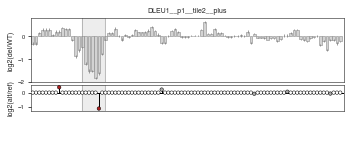

             SNP  snp_pos
134  rs181891917       12
135  rs146951114       59
136  rs565388398       67


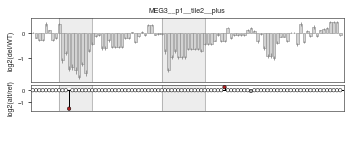

K562
             SNP  snp_pos
126    rs1403538        9
127  rs535708498       21
128  rs538017455       40
129  rs575402821       68
130  rs539663637       78
131  rs558366780       91


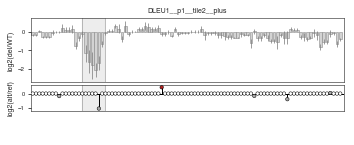

             SNP  snp_pos
134  rs181891917       12
135  rs146951114       59
136  rs565388398       67


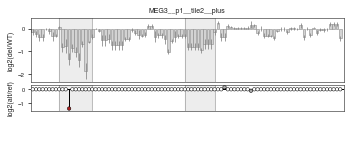

In [41]:
seq_len = 94

for cell, snps, dels in zip(["HepG2", "K562"], [hepg2_snps, k562_snps], [hepg2_dels, k562_dels]):
    print(cell)
    seqs_w_snps = snps["wt_id_new"].unique()
    
    for seq in seqs_w_snps:
        if seq in ["MEG3__p1__tile2__plus", "DLEU1__p1__tile2__plus"]:
            try:
                del_df = dels[seq]
            except KeyError:
                print("deletions not tested")
                print("")
                continue

            # put del_df bps in terms of 1-94
            del_df["delpos_fixed"] = list(range(1, 95))

            # print snp ids
            snp_info = snps[(snps["wt_id_new"] == seq)][["SNP", "snp_pos"]]

            # merge dfs
            snp_df = snps[(snps["wt_id_new"] == seq)][["wt_id_new", "combined_l2fc", "combined_sig", "snp_pos"]]
            merged = del_df.merge(snp_df, left_on="delpos_fixed", right_on="snp_pos", how="left")

            # get everything we need to plot
            prev_p = "no peak"
            starts = []
            ends = []
            for i, p in zip(merged["delpos_fixed"], merged["peak"]):
                if p == "peak" and prev_p == "no peak":
                    starts.append(i)
                elif p == "no peak" and prev_p == "peak":
                    ends.append(i-1)
                prev_p = p
            widths = list(zip(starts, ends))

            scores = list(merged["mean.log2FC"])
            bases = list(merged["seq"])
            yerrs = list(merged["se"])
            scaled_scores = [1] * len(scores)

            snp_vals = list(merged["combined_l2fc"].fillna(0))
            snp_sigs = list(merged["combined_sig"].fillna("NA"))
            
            if "MEG3" in seq:
                print(snp_info)
                plot_peaks_and_snps((5.6, 2), seq_len, seq, widths, scores, yerrs, scaled_scores, 
                                    snp_vals, snp_sigs, bases, "Fig_S17B_%s" % cell, ".")
            if "DLEU" in seq:
                print(snp_info)
                plot_peaks_and_snps((5.6, 2), seq_len, seq, widths, scores, yerrs, scaled_scores, 
                                    snp_vals, snp_sigs, bases, "Fig_4E_%s.pdf" % cell, ".")